<a href="https://colab.research.google.com/github/DaylaHoang/Portfolio-Optimization/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
#Import essensial libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [74]:
#Define the list of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

In [75]:
#Set the end date to today
end_date = datetime.today()

In [76]:
#Set the date to 10 years ago
start_date = end_date - timedelta(days=365*10)
print(start_date)

2015-01-01 03:43:03.417453


In [77]:
#Download Adjusted Close Prices
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [78]:
print(adj_close_df)

                  AAPL        MSFT       GOOGL        AMZN        TSLA
Date                                                                  
2015-01-02   24.347176   40.232845   26.381865   15.426000   14.620667
2015-01-05   23.661274   39.862881   25.879185   15.109500   14.006000
2015-01-06   23.663504   39.277805   25.240503   14.764500   14.085333
2015-01-07   23.995321   39.776844   25.166271   14.921000   14.063333
2015-01-08   24.917265   40.946995   25.253954   15.023000   14.041333
...                ...         ...         ...         ...         ...
2024-12-20  254.490005  436.600006  191.410004  224.919998  421.059998
2024-12-23  255.270004  435.250000  194.630005  225.059998  430.600006
2024-12-24  258.200012  439.329987  196.110001  229.050003  462.279999
2024-12-26  259.019989  438.109985  195.600006  227.050003  454.130005
2024-12-27  255.589996  430.529999  192.759995  223.750000  431.660004

[2514 rows x 5 columns]


In [79]:
#Calculate Lognormal Returns for each ticker
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [80]:
#Calculate Covariance Matrix using annualized log returns
cov_matrix = log_returns.cov()*252
print(cov_matrix)

           AAPL      MSFT     GOOGL      AMZN      TSLA
AAPL   0.081065  0.052927  0.049051  0.051777  0.068880
MSFT   0.052927  0.073640  0.055242  0.058468  0.062883
GOOGL  0.049051  0.055242  0.080814  0.060215  0.059957
AMZN   0.051777  0.058468  0.060215  0.106725  0.073067
TSLA   0.068880  0.062883  0.059957  0.073067  0.324978


In [81]:
#Calculate the Portfolio Standard Deviation
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [82]:
#Calculate the Expected Return
def expected_return(weights,log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [83]:
#Calculate the Sharpe Ratio
def sharpe_ratio (weights,log_returns,risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [84]:
#Set the risk-free rate
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='fa33ca8b9d11ef777744a89d4b9576b9')
ten_year_treasury_rate = fred.get_series('DGS10') / 100
#Set the risk_free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0458


In [85]:
#Define the function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, risk_free_rate)

In [86]:
#Set the constraints and bounds
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [87]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [88]:
# Optimize the weights to maximize Sharpe Ratio
#'SLSQP' stands for Sequential Least Squares Quandratic Programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [89]:
#Get the optimal weights
optimal_weights = optimized_results.x

In [90]:
#Display analytics of the optimal portfolio
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Annual Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAPL: 0.2689
MSFT: 0.3310
GOOGL: 0.0000
AMZN: 0.2927
TSLA: 0.1075

Expected Annual Return: 0.2570
Annual Volatility: 0.2622
Sharpe Ratio: 0.8055


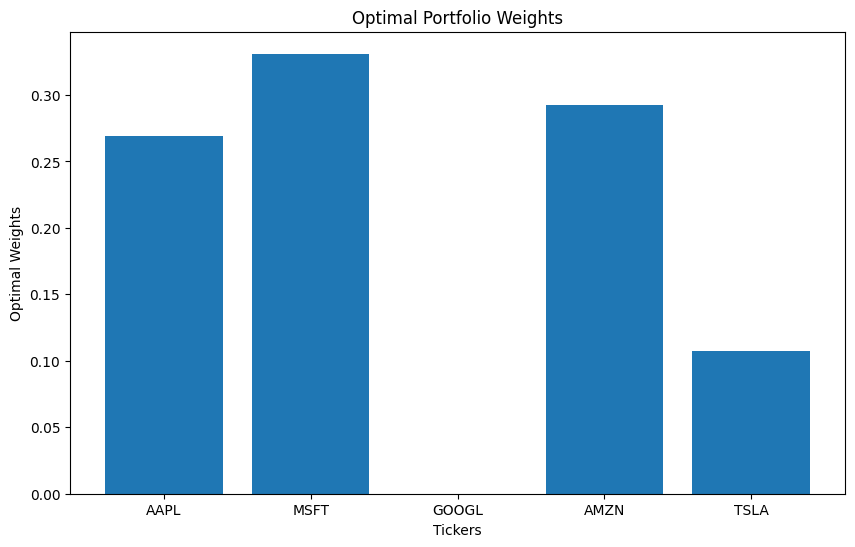

In [91]:
#Display the final portfolio in a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)
plt.xlabel('Tickers')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()